# FlowsheetTools.jl Demonstration
FlowsheetTools.jl is a simply library for dealing with flowsheets (components, streams, unitops, boundaries and flowsheets).
It can be used as a platform for running custom models, for example when fitting kinetic parameters to pilot plant data, where the operating unit is more complicated than a single reactor.
The primary intended purpose however, was for process analytics - generating KPIs on a flowsheet and reconciling mass balances for generic flowsheets.

In [1]:
using FlowsheetTools, Statistics

## Components

We need a ComponentList to hold all the components, so we know where to find them later

In [2]:
syscomps = ComponentList()

Component list:


You can read them from a folder with saved components

In [3]:
count = readcomponentlist!(syscomps, "components", ["Ethylene", "Ethane", "Hydrogen"])

3

Or define them directly

In [4]:
@comp begin
    N --> 2
end "Nitrogen" syscomps

Component: Nitrogen

  Atom		Count
---------------------
   N 		   2


And then save them to file to re-use later.

In [5]:
writecomponent(joinpath("components/", "Nitrogen.comp"), syscomps["Nitrogen"])

22

## Streams

As for components, we create a container stream list to hold the streams so we have something to iterate through later.

In [6]:
sysstreams = StreamList()

Stream list:

Streams:
	Empty list


You can create the streams directly with instantaneous flows.
This can be in either mass or molar flows.
The units are not specified - if you assume the mass flows are in kg/h, then the molar equivalent is kmol/hr, but this could as easily be lb/week and lbmole/week.

In [7]:
@stream mass begin
    "Ethylene" --> 2.8053
    "Ethane" --> 27.06192
    "Hydrogen" --> 2.21738
end "Test" syscomps sysstreams

@stream mole begin
    "Ethane" --> 0.9
    "Hydrogen" --> 1.1
    "Ethylene" --> 0.1
end "Product" syscomps sysstreams

Stream: Product

┌─────────────┬──────────┬─────────┬──────────┬──────────┐
│             │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │
├─────────────┼──────────┼─────────┼──────────┼──────────┤
│ Mass flows  │   2.8053 │ 27.0619 │  2.21738 │      0.0 │
│ Molar flows │      0.1 │     0.9 │      1.1 │      0.0 │
└─────────────┴──────────┴─────────┴──────────┴──────────┘

Total mass flow: 32.085

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │        2.0 │
│    N │        0.0 │
│    H │        8.0 │
└──────┴────────────┘


One stream here was specified as mass flows, the other as molar flows, but there streams are the same and the missing flows (mass/mole) are calculated automatically in the constructor.

We can quickly check if the molar flows are identical:

In [8]:
sysstreams["Test"].moleflows .≈ sysstreams["Product"].moleflows

1×4 TimeSeries.TimeArray{Bool, 2, Dates.DateTime, BitMatrix} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬───────────────────┬───────────────┬─────────────────────
│                     │ Ethylene_Ethylene │ Ethane_Ethane │ Hydrogen_Hydrogen  ⋯
├─────────────────────┼───────────────────┼───────────────┼─────────────────────
│ 0000-01-01T00:00:00 │              true │          true │              true  ⋯
└─────────────────────┴───────────────────┴───────────────┴─────────────────────
                                                                1 column omitted

Or, more conveniently, directly with the `≈` or `==` operators.
Keep in mind that using `==` for floating point values is likely to give `false` when you would expect `true`, so it is recommende to rather use `≈` (`\approx<tab>`)

In [9]:
sysstreams["Test"] ≈ sysstreams["Product"]

true

In [10]:
sysstreams["Test"] == sysstreams["Product"]

false

And, for the skeptical members of the audience, we can also check the atomic flows:

In [11]:
all(getindex.(values(sysstreams["Test"].atomflows), "C") .== getindex.(values(sysstreams["Product"].atomflows), "C"))

true

In [12]:
all(getindex.(values(sysstreams["Test"].atomflows), "H") .== getindex.(values(sysstreams["Product"].atomflows), "H"))

true

When we want to deal with streams with multiple historic data points, we read them from a file.

First, start with a new, empty stream list:

In [13]:
sysstreams = StreamList()

Stream list:

Streams:
	Empty list


Then we read the streams from file.

In [14]:
sysstreams["Feed"] = readstreamhistory(joinpath("streamhistories", "FeedStream.csv"), "Feed", syscomps; ismoleflow=true)
sysstreams["Product"] = readstreamhistory(joinpath("streamhistories", "ProdStream.csv"), "Product", syscomps; ismoleflow=true)

Stream: Product

Mass flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┤
│ 2020-01-01T00:00:00 │  2.66076 │ 84.9202 │ 0.215866 │      0.0 │
│ 2020-01-01T06:00:00 │  2.99313 │ 93.3901 │ 0.194023 │      0.0 │
│ 2020-01-02T00:00:00 │  2.86944 │ 88.1101 │ 0.186885 │      0.0 │
│ 2020-01-02T06:00:00 │  2.98391 │ 88.3229 │  0.20051 │      0.0 │
│ 2020-01-03T00:00:00 │  3.01277 │ 92.5947 │ 0.217602 │      0.0 │
│          ⋮          │    ⋮     │    ⋮    │    ⋮     │    ⋮     │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┘
                                                   22 rows omitted

Molar flows:
┌─────────────────────┬───────────┬─────────┬───────────┬──────────┐
│           timestamp │  Ethylene │  Ethane │  Hydrogen │ Nitrogen │
│      Dates.Da

In the data files (*.csv), we had columns of data for ethylene, ethane and hydrogen, but or list of components also include nitrogen.
We automatically set zero flows for amy components not in the file, so all the streams contain all of the components (for our sanity).

We can still add components to the component list after the streams were created.
If we do, then we should also call `refreshcomplist(streamlist)` to add zero flows for all of these new components to the existing streams in the stream list.

In [15]:
@comp begin
    Ar --> 1
end "Argon" syscomps

refreshcomplist(sysstreams)

sysstreams["Feed"];

## What can we do with streams?

Operations defined on streams include addition and multiplication with a scalar. Addition of streams is effectively a mixer unit.
Multiplication is used to allow correction factors for mass balance reconciliation.

In [16]:
sysstreams["Prod2"] = 2.0*sysstreams["Product"]

Stream: Product

Mass flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  5.32151 │  169.84 │ 0.431731 │      0.0 │     0.0 │
│ 2020-01-01T06:00:00 │  5.98625 │  186.78 │ 0.388047 │      0.0 │     0.0 │
│ 2020-01-02T00:00:00 │  5.73888 │  176.22 │ 0.373769 │      0.0 │     0.0 │
│ 2020-01-02T06:00:00 │  5.96781 │ 176.646 │  0.40102 │      0.0 │     0.0 │
│ 2020-01-03T00:00:00 │  6.02554 │ 185.189 │ 0.435204 │      0.0 │     0.0 │
│          ⋮          │    ⋮     │    ⋮    │    ⋮     │    ⋮     │    ⋮    │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┴─────────┘
                                                             22 rows omitted

Molar flows:
┌─────────────────────┬──────────

Check the answer

In [17]:
sysstreams["Prod2"] == 2.0*sysstreams["Product"]

true

Alternatively

In [18]:
all(values(sysstreams["Prod2"].totalmassflow) .== values(2.0 .* sysstreams["Product"].totalmassflow))

true

Note the use of `.==` and `.*` above. Internally the data are stored in `TimeArrays` from `TimeSeries.jl` and only the broadcasted operators are used on `TimeArray`s.

Comparison between `TimeArrays` returns a `TimeArray` and we extract the results as an aray using the `values()` function to get a `BitVector`.

We can also copy streams and copy with a multiplication factor:

In [19]:
copystream!(sysstreams, "Product", "MyStream")
copystream!(sysstreams, "Product", "MyStream2"; factor=2.0)
sysstreams["MyStream2"] ≈ 2.0 * sysstreams["MyStream"]

true

Copy and copy with multiply

In [20]:
copystream!(sysstreams, "Product", "MyStream")
sysstreams["Product"] == sysstreams["MyStream"]

copystream!(sysstreams, "Product", "MyStream2"; factor=2.0) # double the flow!
2.0 * sysstreams["Product"] == sysstreams["MyStream2"]

true

The streams have different names, but we overload `==` to only check the molar flows of each component, so we get the expected answer.

Since the atomic flows are automatically calculated, they will also match

In [21]:
all(getindex.(values(sysstreams["Product"].atomflows), "C") .== getindex.(values(sysstreams["MyStream"].atomflows), "C"))

true

In [22]:
all(getindex.(values(sysstreams["Product"].atomflows), "H") .== getindex.(values(sysstreams["MyStream"].atomflows), "H"))

true

In [23]:
all(getindex.(values(sysstreams["Product"].atomflows), "N") .== getindex.(values(sysstreams["MyStream"].atomflows), "N"))

true

We can also rename or delete streams from the stream list:

In [24]:
renamestream!(sysstreams, "MyStream", "Dummy")
deletestream!(sysstreams, "Dummy")
sysstreams

Stream list:

Streams:
  Feed
  Product
  Prod2
  MyStream2

Components:
  Ethylene
  Ethane
  Hydrogen
  Nitrogen
  Argon

Data length:	27
Data starts:	2020-01-01T00:00:00
Data ends:	2020-01-14T00:00:00


# UnitOps, Boundaries and KPIs

Let's start with an empty stream list

In [25]:
sysstreams = StreamList()

@stream mole begin
    "Hydrogen" --> 1.1
end "H2" syscomps sysstreams

@stream mole begin
    "Ethylene" --> 0.1
    "Ethane" --> 0.9
end "C2" syscomps sysstreams

Stream: C2

┌─────────────┬──────────┬─────────┬──────────┬──────────┬───────┐
│             │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │ Argon │
├─────────────┼──────────┼─────────┼──────────┼──────────┼───────┤
│ Mass flows  │   2.8053 │ 27.0619 │      0.0 │      0.0 │   0.0 │
│ Molar flows │      0.1 │     0.9 │      0.0 │      0.0 │   0.0 │
└─────────────┴──────────┴─────────┴──────────┴──────────┴───────┘

Total mass flow: 29.867

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │        2.0 │
│    N │        0.0 │
│   Ar │        0.0 │
│    H │        5.8 │
└──────┴────────────┘


We can also add an empty stream, since we don't measure the mixed stream. We'll calculate it with a mixer model later.

In [26]:
sysstreams["Mixed"] = emptystream(sysstreams, "Mixed")

@stream mole begin
    "Ethylene" --> 0.0
    "Ethane" --> 1.0
    "Hydrogen" --> 1.0
end "Product" syscomps sysstreams

Stream: Product

┌─────────────┬──────────┬─────────┬──────────┬──────────┬───────┐
│             │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │ Argon │
├─────────────┼──────────┼─────────┼──────────┼──────────┼───────┤
│ Mass flows  │      0.0 │ 30.0688 │   2.0158 │      0.0 │   0.0 │
│ Molar flows │      0.0 │     1.0 │      1.0 │      0.0 │   0.0 │
└─────────────┴──────────┴─────────┴──────────┴──────────┴───────┘

Total mass flow: 32.085

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │        2.0 │
│    N │        0.0 │
│   Ar │        0.0 │
│    H │        8.0 │
└──────┴────────────┘


Now we define some unit operations. As with components and streams we need a container to be able to access the streams again later.

In [27]:
sysunitops = UnitOpList()

@unitop begin
    inlets --> ["H2", "C2"]
    outlets --> ["Mixed"]
    calc --> mixer!
end "Mixer" sysstreams sysunitops

Unit Operation:  Mixer
Feed streams:    ["H2", "C2"]

Product streams: ["Mixed"]


And to execute the unit operation, we simply call it.

In [28]:
sysunitops["Mixer"]()

This `UnitOp` takes the required inlet and outlet streams, but is also assigned a calculation.
In this case, it is the predefined `mixer!` function, which is a simple stream mixer.
This can however be any user-defined function, with the correct form.
These calculations will supply the contents of the outlet streams based on the inlets streams and supplied model parameters.
They are only needed if there is no information on the outlet streams.

In [29]:
@unitop begin
    inlets --> ["Mixed"]
    outlets --> ["Product"]
end "Reactor" sysstreams sysunitops

Unit Operation:  Reactor
Feed streams:    ["Mixed"]

Product streams: ["Product"]


Our `Reactor` does not have an associated calculation. It is just a node in the flowsheet graph, so we shall need information for all of the inlets and outlets.

Let's split the product a little. We'll need some empty streams.

In [30]:
sysstreams["Product1"] = emptystream(sysstreams, "Product1");
sysstreams["Product1a"] = emptystream(sysstreams, "Product1a");
sysstreams["Product1b"] = emptystream(sysstreams, "Product1b");
sysstreams["Product2"] = emptystream(sysstreams, "Product2");
sysstreams["Product3"] = emptystream(sysstreams, "Product3");

Let's also add a dummy stream with a fixed composition. We don't need it here, but it is easy to do

In [31]:
sysstreams["Dummy"] = fixedstream(sysstreams, "Dummy", [10.0, 0.0, 0.0, 0.0, 0.1])

Stream: Dummy

┌─────────────┬──────────┬────────┬──────────┬──────────┬────────────┐
│             │ Ethylene │ Ethane │ Hydrogen │ Nitrogen │      Argon │
├─────────────┼──────────┼────────┼──────────┼──────────┼────────────┤
│ Mass flows  │     10.0 │    0.0 │      0.0 │      0.0 │        0.1 │
│ Molar flows │ 0.356468 │    0.0 │      0.0 │      0.0 │ 0.00250325 │
└─────────────┴──────────┴────────┴──────────┴──────────┴────────────┘

Total mass flow: 10.1

┌──────┬────────────┐
│ Atom │ Molar flow │
├──────┼────────────┤
│    C │   0.712936 │
│    N │        0.0 │
│   Ar │ 0.00250325 │
│    H │    1.42587 │
└──────┴────────────┘


A flow splitter that splits 50% of the product to each of Product1 and Product2. These streams will have identcal compositions

In [32]:
@unitop begin
    inlets --> ["Product"]
    outlets --> ["Product1", "Product2"]
    calc --> flowsplitter!
    params --> [0.5]
end "ProductSplitter" sysstreams sysunitops

sysunitops["ProductSplitter"]()

A component splitter that splits Product1 into Product1a and Product1b.
These streams will have different compositions, with the hydrogen split 50:50, 70% of the ethane going to Product1b and the remainder of Product1, going to Product1b (the last stream listed).

In [33]:
@unitop begin
    inlets --> ["Product1"]
    outlets --> ["Product1a", "Product1b"]
    calc --> componentplitter!
    params --> Dict([
        "Hydrogen" => Dict(["Product1a" => 0.5]),
        "Ethane" => Dict(["Product1b" => 0.3])
    ])
end "ComponentSplitter" sysstreams sysunitops

sysunitops["ComponentSplitter"]()

And then we mix it all again and check that we still have the original Product stream

In [34]:
@unitop begin
    inlets --> ["Product1a", "Product1b", "Product2"]
    outlets --> ["Product3"]
    calc --> mixer!
end "Mixer2" sysstreams sysunitops

sysunitops["Mixer2"]()

Check that the two streams have the same flows

In [35]:
sysstreams["Product"] ≈ sysstreams["Product3"]

true

Mass balances and KPIs are defined on a boundary around a number of unit operations. We therefore define a `Boundary` and list the contained `UnitOp`s

In [36]:
@boundary begin
    unitops --> ["Mixer", "Reactor"]
end b sysunitops

Balance Boundary:

Enclosed units: ["Mixer", "Reactor"]

Closure:
┌─────────────────────┬────────────────────┐
│           timestamp │ Total Mass Closure │
│      Dates.DateTime │            Float64 │
├─────────────────────┼────────────────────┤
│ 0000-01-01T00:00:00 │                1.0 │
└─────────────────────┴────────────────────┘

Combined Feed Mass Flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 0000-01-01T00:00:00 │   2.8053 │ 27.0619 │  2.21738 │      0.0 │     0.0 │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┴─────────┘
Combined Product Mass Flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   

We can look at total mass and elemental closures, as well as the combined in- and outflows.

In [37]:
b.atomclosures

1×1 TimeSeries.TimeArray{Dict{String, Float64}, 1, Dates.DateTime, Vector{Dict{String, Float64}}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬─────────────────────────────────────────────────┐
│                     │ Elemental Closures                              │
├─────────────────────┼─────────────────────────────────────────────────┤
│ 0000-01-01T00:00:00 │ Dict("C"=>1.0, "N"=>-1.0, "Ar"=>-1.0, "H"=>1.0) │
└─────────────────────┴─────────────────────────────────────────────────┘

In [38]:
b.closure

1×1 TimeSeries.TimeArray{Float64, 1, Dates.DateTime, Vector{Float64}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬────────────────────┐
│                     │ Total Mass Closure │
├─────────────────────┼────────────────────┤
│ 0000-01-01T00:00:00 │                1.0 │
└─────────────────────┴────────────────────┘

In [39]:
b.total_in.totalmassflow

1×1 TimeSeries.TimeArray{Float64, 1, Dates.DateTime, Vector{Float64}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬────────────────┐
│                     │ totalmassflows │
├─────────────────────┼────────────────┤
│ 0000-01-01T00:00:00 │        32.0846 │
└─────────────────────┴────────────────┘

In [40]:
b.total_out.totalmassflow

1×1 TimeSeries.TimeArray{Float64, 1, Dates.DateTime, Vector{Float64}} 0000-01-01T00:00:00 to 0000-01-01T00:00:00
┌─────────────────────┬────────────────┐
│                     │ totalmassflows │
├─────────────────────┼────────────────┤
│ 0000-01-01T00:00:00 │        32.0846 │
└─────────────────────┴────────────────┘

We can also define KPIs on the boundary. Here we use the pre-defined KPIs of `conversion(boundary, component)` and `selectivity(boundary, reactant, product)`

In [41]:
conversion(b, "Ethane")

-0.11111111111111106

Ethane was produced, not consumed, so has a negative value for conversion.

In [42]:
(conversion(b, "Ethylene"), conversion(b, "Hydrogen"))

(1.0, 0.09090909090909104)

We had complete conversion of ethylene and only ~9% of hydrogen, due to the large excess fed.

In [43]:
molar_selectivity(b, "Ethylene", "Ethane")

0.9999999999999998

All of the reacted ethylene was converted to ethane.

### For streams with time series data

Now we can repeat this for streams with multiple historic data points attached:

In [44]:
sysstreams = StreamList() # Create a new container and dump the previous streams
sysstreams["C2"] = readstreamhistory(joinpath("streamhistories", "C2.csv"), "C2", syscomps; ismoleflow=true)
sysstreams["H2"] = readstreamhistory(joinpath("streamhistories", "Hydrogen.csv"), "H2", syscomps; ismoleflow=true)
sysstreams["Product"] = readstreamhistory(joinpath("streamhistories", "Product.csv"), "Product", syscomps; ismoleflow=true)
sysstreams["Mixed"] = emptystream(sysstreams, "Mixed");
sysstreams["Product1"] = emptystream(sysstreams, "Product1");
sysstreams["Product1a"] = emptystream(sysstreams, "Product1a");
sysstreams["Product1b"] = emptystream(sysstreams, "Product1b");
sysstreams["Product2"] = emptystream(sysstreams, "Product2");
sysstreams["Product3"] = emptystream(sysstreams, "Product3");

And just to show what happens when we create a fixed composition stream when the streams in the StreamList have time series data

In [45]:
sysstreams["Dummy"] = fixedstream(sysstreams, "Dummy", [10.0, 0.0, 0.0, 0.0, 0.1])

Stream: Dummy

Mass flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│ 2020-01-01T06:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│ 2020-01-02T00:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│ 2020-01-02T06:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│ 2020-01-03T00:00:00 │     10.0 │     0.0 │      0.0 │      0.0 │     0.1 │
│          ⋮          │    ⋮     │    ⋮    │    ⋮     │    ⋮     │    ⋮    │
└─────────────────────┴──────────┴─────────┴──────────┴──────────┴─────────┘
                                                             22 rows omitted

Molar flows:
┌─────────────────────┬──────────┬─

Empty the unit operation list as well, so we start fresh.

In [46]:
sysunitops = UnitOpList()

@unitop begin
    inlets --> ["H2", "C2"]
    outlets --> ["Mixed"]
    calc --> mixer!
end "Mixer" sysstreams sysunitops
sysunitops["Mixer"]()

@unitop begin
    inlets --> ["Mixed"]
    outlets --> ["Product"]
end "Reactor" sysstreams sysunitops

@unitop begin
    inlets --> ["Product"]
    outlets --> ["Product1", "Product2"]
    calc --> flowsplitter!
    params --> [0.5]
end "ProductSplitter" sysstreams sysunitops
sysunitops["ProductSplitter"]()

@unitop begin
    inlets --> ["Product1"]
    outlets --> ["Product1a", "Product1b"]
    calc --> componentplitter!
    params --> Dict([
        "Hydrogen" => Dict(["Product1a" => 0.5]),
        "Ethane" => Dict(["Product1b" => 0.3])
    ])
end "ComponentSplitter" sysstreams sysunitops
sysunitops["ComponentSplitter"]()

@unitop begin
    inlets --> ["Product1a", "Product1b", "Product2"]
    outlets --> ["Product3"]
    calc --> mixer!
end "Mixer2" sysstreams sysunitops
sysunitops["Mixer2"]()

Check that the two streams have the same flows.

In [47]:
sysstreams["Product"] ≈ sysstreams["Product3"]

true

Define the mass balance boundary for closures and KPIs

In [48]:
@boundary begin
    unitops --> ["Mixer", "Reactor"]
end b sysunitops

b.atomclosures

b.closure

b.total_in.totalmassflow

b.total_out.totalmassflow

c1 = conversion(b, "Ethane")
c2 = conversion(b, "Ethylene")

sc2 = molar_selectivity(b, "Ethylene", "Ethane")

(mean(values(c1)), mean(values(c2)), mean(values(sc2)))

(-0.11361804202204312, 0.9988638054742306, 0.9999999999999998)

So, we have average conversions of ethane (-11%, meaning it was produced, not consumed), ethylene (99.9%) and selectivity of ethylene conversion to ethane (~100%) similar to the single data point above.

## Mass balance reconciliation

The mass balance reconciliation algorithm is currently *VERY BASIC*! This will be updated at the first opportunity, but will be invisible to the end-user and will not have major impacts on the user interface unless additional user input is required.

To demomstrate the use of the reconciliation tool, we repeat the flowsheet above, but introduce some (artificial) flow measurement errors.

In [49]:
copystream!(sysstreams, "C2", "eC2", factor = 1.05)
copystream!(sysstreams, "H2", "eH2", factor = 0.95)
copystream!(sysstreams, "Product", "eProduct")
sysstreams["eMixed"] = emptystream(sysstreams, "eMixed") # We'll calculate this stream with the mixer model

@unitop begin
    inlets --> ["eH2", "eC2"]
    outlets --> ["eMixed"]
    calc --> mixer!
end "eMixer" sysstreams sysunitops
sysunitops["eMixer"]()

@unitop begin
    inlets --> ["eMixed"]
    outlets --> ["eProduct"]
end "eReactor" sysstreams sysunitops

@boundary begin
    unitops --> ["eMixer", "eReactor"]
end b sysunitops

Balance Boundary:

Enclosed units: ["eMixer", "eReactor"]

Closure:
┌─────────────────────┬────────────────────┐
│           timestamp │ Total Mass Closure │
│      Dates.DateTime │            Float64 │
├─────────────────────┼────────────────────┤
│ 2020-01-01T00:00:00 │           0.958788 │
│ 2020-01-01T06:00:00 │           0.958655 │
│ 2020-01-02T00:00:00 │           0.958268 │
│ 2020-01-02T06:00:00 │           0.958248 │
│ 2020-01-03T00:00:00 │           0.958608 │
│          ⋮          │         ⋮          │
└─────────────────────┴────────────────────┘
                             22 rows omitted

Combined Feed Mass Flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │   3.1588 │ 28.1775 │  2.13952 │  

We can request the correction factors, without applying them.

In [50]:
corrections = calccorrections(b)

Dict{String, Float64} with 3 entries:
  "eH2"      => 1.04648
  "eC2"      => 0.95095
  "eProduct" => 0.998

We can also pass through a custom additional error function to minimize.
We have a custom function that receives a dictionary of the correction factors and can do any arbitrary calculation.
The retured value is added to the weighted square errors of the total mass and element balances.
You can, for example, add distance from equilibrium for a reaction to the reconciliation.

In [51]:
myerr(factorDict) = 100.0 * sum(abs2, 1.0 .- values(factorDict))
corrections = calccorrections(b, myerr)

Dict{String, Float64} with 3 entries:
  "eH2"      => 0.999576
  "eC2"      => 0.988278
  "eProduct" => 1.01187

The previous example uses a constant weight for all elements, but we can specifiy individual weights as well.

In [52]:
weights = Dict(["H" => 1.0, "C" => 1.5, "O" => 1.0, "Ar" => 0.0, "N" => 0.0])
corrections2 = calccorrections(b, setelements=true, elementweights=weights)

Dict{String, Float64} with 3 entries:
  "eH2"      => 1.04676
  "eC2"      => 0.95073
  "eProduct" => 0.997889

`calccorrections` takes a boundary for which to calculate the correction factors, and then optional weights for the total mass balance error and the elemental errors.
These latter values default to 1.0 each. It uses [Ridge Regression](https://www.ibm.com/topics/ridge-regression?_sm_au_=iF5HM658VZnjn6Sr0GLqHKHB1jtC6) with a default λ = 0.1

  function calccorrections_anchor(boundary::BalanceBoundary, anchor::String; totalweight=1.0, elementweight = 1.0,
        setelements = false, elementweights::Dict{String, Float64} = Dict{String, Float64}())

An alternative option is to use an anchor stream, rather than Ridge Regression. The correction factor for the anchor stream will be 1.0, i.e. there is no adjustment.

In [53]:
corrections_a = calccorrections_anchor(b, "eProduct")
corrections_a = calccorrections_anchor(b, "eProduct", myerr)

Dict{String, Float64} with 3 entries:
  "eH2"      => 0.998918
  "eC2"      => 0.983266
  "eProduct" => 1.0

Or again, with inidividual element weights

In [54]:
corrections_a = calccorrections_anchor(b, "eProduct", setelements=true, elementweights=weights)

Dict{String, Float64} with 3 entries:
  "eH2"      => 1.05263
  "eC2"      => 0.952381
  "eProduct" => 1.0

`calccorrections_anchor` takes a boundary for which to calculate the correction factors, an anchor stream, for which the correction is always 1.0 - no change, and then optional weights for the total mass balance error and the elemental errors.
These latter values default to 1.0 each.

  `function calccorrections(boundary::BalanceBoundary, anchor::String; totalweight=1.0, elementweight=1.0)`

We can apply the corrections, with `closemb()`, which will take a `Dict` of correction factors.

In [55]:
b2 = closemb(b, corrections)
b3 = closemb(b, corrections_a)

Balance Boundary:

Enclosed units: ["eMixer", "eReactor"]

Closure:
┌─────────────────────┬────────────────────┐
│           timestamp │ Total Mass Closure │
│      Dates.DateTime │            Float64 │
├─────────────────────┼────────────────────┤
│ 2020-01-01T00:00:00 │            1.02305 │
│ 2020-01-01T06:00:00 │            1.02307 │
│ 2020-01-02T00:00:00 │            1.02312 │
│ 2020-01-02T06:00:00 │            1.02312 │
│ 2020-01-03T00:00:00 │            1.02307 │
│          ⋮          │         ⋮          │
└─────────────────────┴────────────────────┘
                             22 rows omitted

Combined Feed Mass Flows:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  2.97311 │ 26.5212 │  2.25117 │  

Let's compare the raw and reconciled closures:

In [56]:
(mean(values(b.closure)), mean(values(b2.closure)), mean(values(b3.closure)))

(0.9587129966186322, 0.9808892557804018, 1.0230590006155555)

We can now write corrected streams back to file

In [57]:
writestreamhistory(sysstreams["C2"], "corrected.csv")

We can also request some information from a bounary. This is given in table form, packed into a string.

In [58]:
print(showdata(b2))

Mass Balance Boundary:
----------------------

Total Mass Flows In:
┌─────────────────────┬──────────┬─────────┬──────────┬──────────┬─────────┐
│           timestamp │ Ethylene │  Ethane │ Hydrogen │ Nitrogen │   Argon │
│      Dates.DateTime │  Float64 │ Float64 │  Float64 │  Float64 │ Float64 │
├─────────────────────┼──────────┼─────────┼──────────┼──────────┼─────────┤
│ 2020-01-01T00:00:00 │  3.12177 │ 27.8472 │  2.13862 │      0.0 │     0.0 │
│ 2020-01-01T06:00:00 │  3.12581 │ 27.9801 │   2.1006 │      0.0 │     0.0 │
│ 2020-01-02T00:00:00 │   2.6834 │ 30.7493 │  2.10979 │      0.0 │     0.0 │
│ 2020-01-02T06:00:00 │  3.08835 │ 30.2827 │  2.09813 │      0.0 │     0.0 │
│ 2020-01-03T00:00:00 │  3.01087 │ 28.8085 │  2.13132 │      0.0 │     0.0 │
│ 2020-01-03T06:00:00 │  2.98263 │ 29.6122 │  2.09118 │      0.0 │     0.0 │
│ 2020-01-04T00:00:00 │  3.19725 │  27.627 │  2.14358 │      0.0 │     0.0 │
│ 2020-01-04T06:00:00 │  3.16428 │ 28.2181 │  2.10313 │      0.0 │     0.0 │
│ 2020-0

## Flowsheets

Lastly, for convenience, we can creat a `Flowsheet` object, which holds a number of unit operations and an execution order.
If the flowsheet is then executed, each unit operation is execute in order, as specified.
Unit operations can be added or deleted with utility functions and the execution order can be modified.

In [59]:
fs = Flowsheet(sysunitops, ["Reactor"], [1])
addunitop!(fs, ["Mixer", "ProductSplitter", "ComponentSplitter", "Mixer2"])

fs()

1  Reactor
2  Mixer
3  ProductSplitter
4  ComponentSplitter
5  Mixer2


Lastly, once a `Flowsheet` object is created, a block flow diagram can also be generated.

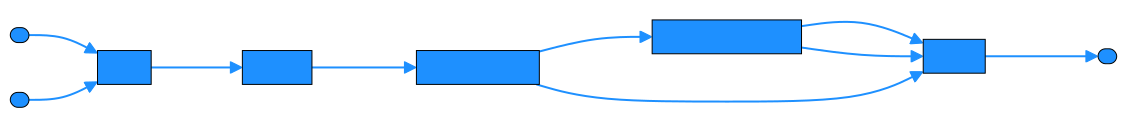

"./myflowsheet.svg"

In [60]:
generateBFD(fs, "./myflowsheet.svg")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*